In [1]:
import matplotlib.pyplot as plt

import numpy as np #importa a biblioteca usada para trabalhar com vetores e matrizes
import pandas as pd #importa a biblioteca usada para trabalhar com dataframes
import util
import scipy.optimize
from numba import jit,njit
from scipy.sparse import bsr_matrix

#importa o arquivo e extrai as features
Xfeatures, Y = util.extract_features('datasets/everything.csv', rep='ngrams',n=3)

['lol' 'ol' 'atl' 'tle' 'lea']


In [2]:
@njit
def sigmoid(z):
    """
    Calcula a funcao sigmoidal  
    """
    
    # Você precisa retornar a variável g corretamente
    #
    # se z for um valor inteiro, inicializa g com 0
    #if isinstance(z, int):
    #    g = 0
    
    # se z não é um inteiro, significa que é um array e, portanto, inicia com um vetor de zeros com a dimensão do array
    #else:
    #g = np.zeros( z.shape );

    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # Instrucoes: Calcule a sigmoid de cada valor de z 
    #                (z pode ser uma matriz, vetor ou escalar).

    g = 1 / (1 + np.exp(-z))

    ##########################################################################
    
    return g

In [3]:
def funcaoCustoReg(theta, X, Y, lambda_reg):
    """
    Calcula o custo da regressao logística
    
       J = COMPUTARCUSTO(X, y, theta) calcula o custo de usar theta como 
       parametro da regressao logistica para ajustar os dados de X e y    
    """
    
    # Initializa algumas variaveis uteis
    m = len(Y) #numero de exemplos de treinamento

    # Voce precisa retornar a seguinte variavel corretamente
    J = 0
    grad = np.zeros( len(theta) )
    
    # eps é um parâmetro de tolerância para a função sigmoide 
    # para evitar erro de precisão numérica, é preciso garantir que 1-sigmoid(theta'*x) >= eps
    eps = 1e-15
    
    
    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # Instrucoes: Calcule o custo de uma escolha particular de theta.
    #             Voce precisa armazenar o valor do custo em J.
    #             Calcule as derivadas parciais e encontre o valor do gradiente
    #             para o custo com relacao ao parametro theta
    # Obs: grad deve ter a mesma dimensao de theta
    
    Z = sigmoid(np.matmul(theta,X.T))
    lambda_vec = lambda_reg/m * theta
    lambda_vec[0] = 0
    
    J = 1/m * np.sum(-Y * np.log(Z + eps) - (1 - Y) * np.log(1 - Z + eps)) + lambda_reg/(2*m) * np.sum(theta ** 2)
    grad = 1/m * np.matmul(X.T, Z - Y) + lambda_vec           

    ##########################################################################
    
    return J, grad

In [4]:
def treinamento(X, Y, lambda_reg, iteracoes):
    
    # se for vazio, retorna None 
    if len(Y)==0:
        return None
    
    m, n = X.shape # m = qtde de objetos e n = qtde de atributos por objeto
    
    theta = np.zeros(n) # Inicializa parâmetros que serao ajustados
    
    # minimiza a funcao de custo
    result = scipy.optimize.minimize(fun=funcaoCustoReg, x0=theta, args=(X.astype(float), Y, lambda_reg),  
                method='L-BFGS-B', jac=True, options={'maxiter': iteracoes, 'disp':False})

    # coleta os thetas retornados pela função de minimização
    theta = result.x
    
    return theta

In [5]:
def predicao(theta, X):
    """
    Prediz se a entrada pertence a classe 0 ou 1 usando o parametro
    theta obtido pela regressao logistica
    
    p = PREDICAO(theta, X) calcula a predicao de X usando um 
    limiar igual a 0.5 (ex. se sigmoid(theta'*x) >= 0.5, classe = 1)
    """   
    
    # Numero de exemplos de treinamento
    m = X.shape[0]
    
    # Você precisa retornar a seguinte variavel corretamente
    p = np.zeros(m, dtype=int) 
    
    
    ########################## COMPLETE O CÓDIGO AQUI  ########################
    # Instrucoes: Complete o codigo a seguir para fazer predicoes usando
    # os paramentros ajustados pela regressao logistica. 
    # p devera ser um vetor composto somente por 0's e 1's
    
    p = np.vectorize(lambda x: x >= 0.5)(sigmoid(np.matmul(theta,X.T)))
    ##########################################################################
    
    return p

In [6]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
Xk, Yk = Xfeatures[idx_perm, :], Y[idx_perm]

# define a porcentagem de dados que irao compor o conjunto de treinamento
pTrain = 0.8

# obtem os indices dos dados da particao de treinamento e da particao de teste
train_index, test_index = util.stratified_holdOut(Yk, pTrain)

X_train, X_test = Xk[train_index, :], Xk[test_index, :];
Y_train, Y_test = Yk[train_index], Yk[test_index];

train_index, val_index = util.stratified_holdOut(Y_train, pTrain)

X_train_v, X_val = X_train[train_index, :], X_train[val_index, :]
Y_train_v, Y_val = Y_train[train_index], Y_train[val_index]

print('Numero de dados de validação: %d' %(X_val.shape[0]))

Numero de dados de validação: 444


In [7]:
def gridSearch(X, Y, Xval, Yval):
    """
    Retorna o melhor valor para os parametros lamba da regularizacao da Regressao Logistica.
    
    Parametros
    ----------
    X : matriz com os dados de treinamento
    
    Y : vetor com as classes dos dados de treinamento
    
    Xval : matriz com os dados de validacao
    
    Yval : vetor com as classes dos dados de validacao
    
    Retorno
    -------
    bestReg: o melhor valor para o parametro de regularizacao
    
    """
    
    # inicializa a variável que deverá ser retornada pela função
    bestReg = -100
    
    # Configura o numero de interacaoes da regressao logistica
    iteracoes = 500
    
    # valores que deverao ser testados para o parametro de regularizacao 
    reg = [0,0.5,1,10,50,100];
        
    ########################## COMPLETE O CÓDIGO AQUI  ###############################
    # Instrucoes: Complete esta função para retornar os melhores valores do parametro
    #             de regularizacao da regressao Logistica. 
    #
    #             Você pode calcular o desempenho do classificador atraves da funcao
    #             relatorioDesempenho() criada anteriormente. Use a acuracia para decidir
    #             o melhor parametro.            
    #
    
    perf = []
    
    def regmax(i):
        theta = treinamento(X, Y, i, iteracoes)
        p = predicao(Xval, theta)
        cm = util.get_confusionMatrix(Yval, p, [0,1])
        results = util.relatorioDesempenho(cm, [0,1])
        return results['acuracia']
    
    vregmax = np.vectorize(regmax, otypes=['float'])
    perf = vregmax(reg)

    '''
    for i in reg:
        theta = treinamento(X, Y, i, iteracoes)
        p = predicao(Xval, theta)
        cm = get_confusionMatrix(Yval, p, [0,1])
        results = relatorioDesempenho(cm, [0,1])
        perf.append(results['acuracia'])
    '''
        
    bestReg = reg[np.argmax(perf)]

    ################################################################################## 

    return bestReg

# chama a função que faz a busca em grade
bestRegularization = gridSearch(X_train_v, Y_train_v, X_val, Y_val)
print(bestRegularization)

0.5


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


C:\Users\Gabriel\Documents\UFSCar\BCC7\AM\AM-2019-1\util.py:270: RuntimeWarning: invalid value encountered in true_divide
  revocacao = vp / (vp + fn)


32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298


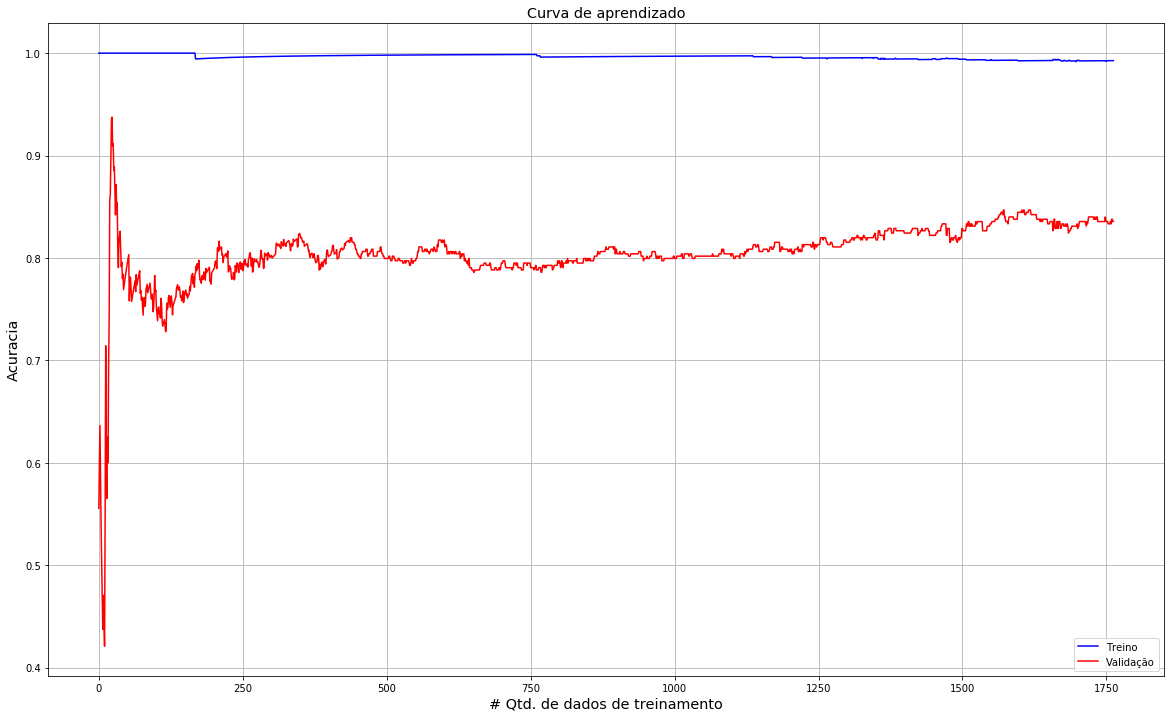

In [8]:
def curva_aprendizado(X, Y, Xval, Yval):
    """
    Funcao usada gerar a curva de aprendizado.
  
    Parametros
    ----------
  
    X : matriz com os dados de treinamento
  
    Y : vetor com as classes dos dados de treinamento
  
    Xval : matriz com os dados de validação
  
    Yval : vetor com as classes dos dados de validação
  
    """

    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []

    # inicializa o parametro de regularizacao da regressao logistica
    lambda_reg = bestRegularization
        
    # Configura o numero de interacaoes da regressao logistica
    iteracoes = 500
        
    ########################## COMPLETE O CÓDIGO AQUI  ###############################
    #  Instrucoes: Complete o codigo para gerar o gráfico da curva de aprendizado.
    #           Comece o treinamento com as primeiras 10 amostras da base de dados de 
    #           treinamento e calcule a acuracia do classificador tanto nos dados de
    #           treinamento já apresentados, quando na base de validacao. 
    #           Depois disso, adicione mais um dado para treinamento e calcule novamente 
    #           o desempenho. Continue adicionando um dado por vez ate todos os dados de 
    #           treinamento serem usados. Nas listas perf_train e perf_val, guarde a acuracia 
    #           obtida nos dados de treinamento e na base de validacao a cada nova adicao de 
    #           dados para treinamento.
    
    for i in np.arange(9, X.shape[0] - 1):
        print(i)
        theta = treinamento(X[:i], Y[:i], lambda_reg, iteracoes)
        # Teste
        p = predicao(X[:i], theta)
        cm = util.get_confusionMatrix(Y[:i], p, [0,1])
        results = util.relatorioDesempenho(cm, [0,1])
        perf_train.append(results['acuracia'])
        # Validação
        p = predicao(Xval[:i], theta)
        cm = util.get_confusionMatrix(Yval[:i], p, [0,1])
        results = util.relatorioDesempenho(cm, [0,1])
        perf_val.append(results['acuracia'])

    ##################################################################################
       
    # Define o tamanho da figura 
    plt.figure(figsize=(20,12))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'Acuracia',fontsize='x-large') 

    # Define o título do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()
    
curva_aprendizado(X_train_v, Y_train_v, X_val, Y_val)

In [9]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
Xk, Yk = Xfeatures[idx_perm, :], Y[idx_perm]

nFolds = 10
classes = [0,1]
iteracoes=1000
folds = util.stratified_kfolds(Yk, nFolds, classes) 

k=1
resultados=[]
for train_index, test_index in folds:
    print('\n-----------\n%d-fold: \n-----------\n' % (k) )

    # se train_index ou test_index forem vazios, interrompe o laco de repeticao
    if len(train_index)==0 or len(test_index)==0: 
        print('\tErro: o vetor com os indices de treinamento ou o vetor com os indices de teste esta vazio')      
        break
        
    totalFold = len(train_index)+len(test_index)

    X_train, X_test = Xk[train_index, :], Xk[test_index, :];
    Y_train, Y_test = Yk[train_index], Yk[test_index];
    
    # separa os dados de treinamento em treinamento e validacao
    pTrain = 0.8
    train_index_v, val_index = util.stratified_holdOut(Y_train, pTrain)

    # chama a função que faz a busca em grade
    bestRegularization = gridSearch(X_train_v, Y_train_v, X_val, Y_val)

    # executa o treinamento com o melhor parâmetro de regularização encontrado
    theta = treinamento(X_train,Y_train,bestRegularization,iteracoes)

    # classifica os dados de teste
    Y_pred = predicao(X_test, theta)

    # Compute confusion matrix
    cm = util.get_confusionMatrix(Y_test, Y_pred, classes)

    # Gera o relatório de desempenho
    #print('\n\n\n\t'+"="*50+'\n\tMelhor parametro de regularizacao: %1.6f' %bestRegularization)
    print('\n\tResultado no fold atual usando o melhor parametro encontrado:')
    auxResults = util.relatorioDesempenho(cm, classes, imprimeRelatorio=True)

    # adiciona os resultados do fold atual na lista de resultados
    resultados.append( auxResults ) 
        
    k+=1


-----------
1-fold: 
-----------


	Resultado no fold atual usando o melhor parametro encontrado:

	Revocacao   Precisao   F-medida   Classe
	0.841       0.867      0.854      0
	0.882       0.858      0.870      1
	------------------------------------------------
	0.861       0.863      0.862      Média macro
	0.862       0.862      0.862      Média micro

	Acuracia: 0.862

-----------
2-fold: 
-----------


	Resultado no fold atual usando o melhor parametro encontrado:

	Revocacao   Precisao   F-medida   Classe
	0.841       0.799      0.819      0
	0.806       0.847      0.826      1
	------------------------------------------------
	0.823       0.823      0.823      Média macro
	0.822       0.822      0.822      Média micro

	Acuracia: 0.822

-----------
3-fold: 
-----------


	Resultado no fold atual usando o melhor parametro encontrado:

	Revocacao   Precisao   F-medida   Classe
	0.833       0.840      0.837      0
	0.854       0.848      0.851      1
	---------------------------

In [10]:
print('\nResultado final da classificação:')
util.mediaFolds( resultados, classes )


Resultado final da classificação:

	Revocacao   Precisao   F-medida   Classe
	0.840       0.843      0.841      0
	0.856       0.855      0.855      1
	---------------------------------------------------------------------
	0.848       0.849      0.848      Média macro
	0.848       0.848      0.848      Média micro

	Acuracia: 0.848
